In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Import machine learning - if I have more time, would love to do some Linear Regression Analysis
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split #split 
from sklearn.metrics import r2_score, mean_squared_error #metrics
import os

# 1. Business Understanding
# AirBnB is a community-based online platform for listing and renting local homes.  It connects hosts and travelers
# and facilitates the process of renting without owning any rooms itself.  Moreover, it cultivates a sharing-economy by 
# allowing property owners to rent out private flats.  This project is to find out the 3 questions that I have regarding to
# Seattle AirBnB:
# 1. What are the top three locations with the most AirBnB listings?
# 2. Does the listing price change over the season or month? If so, when is the most economical time to visit Seattle?
# 3. How does the other factors such as # of bedrooms or review scores impact the listing price?

# 2. Data Understanding
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 2a. Gathering the data
listings_df = pd.read_csv('/kaggle/input/listings.csv')
calendar_df = pd.read_csv('/kaggle/input/calendar.csv')
review_df = pd.read_csv('/kaggle/input/reviews.csv')

# 2b. Assessing the data
listings = listings_df['id'].count()
hosts = len(listings_df['host_id'].unique())

print('The listings.csv dataset provides information on %d listings provides by %d hosts.' % (listings, hosts))

start_date = calendar_df['date'].min()
end_date = calendar_df['date'].max()
num_rows = calendar_df.shape[0]

print('The calendar.csv dataset includes %d rows that starts on %s and ends on %s.' % (num_rows, start_date, end_date))

num_reviews = review_df.shape[0]

print('The reviews.csv dataset include %d reviews.' % (num_reviews))

/kaggle/input/calendar.csv
/kaggle/input/reviews.csv
/kaggle/input/listings.csv
The listings.csv dataset provides information on 3818 listings provides by 2751 hosts.
The calendar.csv dataset includes 1393570 rows that starts on 2016-01-04 and ends on 2017-01-02.
The reviews.csv dataset include 84849 reviews.


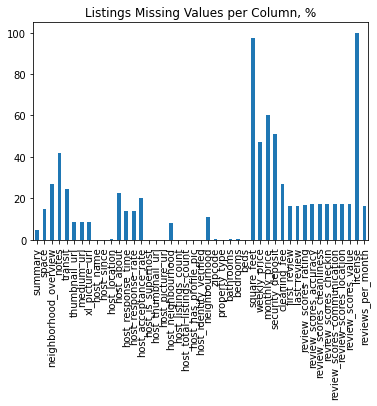

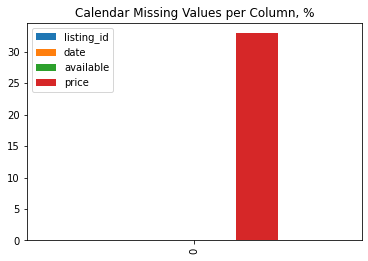

In [2]:
# 3. Prepare the data
# 3a. Cleaning the data
listings_missing = listings_df.isnull().mean()*100
calendar_missing = pd.DataFrame([calendar_df.isnull().mean()*100])

listings_missing_columns = listings_missing[listings_missing > 0]

listings_missing_columns.plot.bar(title='Listings Missing Values per Column, %')
calendar_missing.plot.bar(title='Calendar Missing Values per Column, %')

In [3]:

listings_df.columns.values

array(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       

In [4]:
# 3b. Build a dataframe that only includes a subset of columns which are related to our questions

listings_df = listings_df.rename(index=str, columns={"id":"listing_id"})

# 3c. Drop the irrelevant columns by building a new dataframe with the necessary columns                  
df = listings_df[['listing_id','host_location','host_neighbourhood','property_type','room_type','accommodates','bathrooms','bedrooms','beds','price', 'weekly_price','monthly_price','number_of_reviews','review_scores_rating','reviews_per_month']]
df.head()

,listing_id,host_location,host_neighbourhood,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,number_of_reviews,review_scores_rating,reviews_per_month
0,241032,"Seattle, Washington, United States",Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,$85.00,NaN,NaN,207,95.0,4.07
1,953595,"Seattle, Washington, United States",Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,$150.00,"$1,000.00","$3,000.00",43,96.0,1.48
2,3308979,"Seattle, Washington, United States",Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,$975.00,NaN,NaN,20,97.0,1.15
3,7421966,"Seattle, Washington, United States",Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,$100.00,$650.00,"$2,300.00",0,NaN,NaN
4,278830,"Seattle, Washington, United States",Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,$450.00,NaN,NaN,38,92.0,0.89


In [5]:
# 3d. Find # of NaN value in the data frame & drop NaN rows
(len(df)-df.count())/len(df)*100

df1 = df.dropna(axis=0)
pd.options.mode.chained_assignment = None

df1['price'] = df1['price'].str.replace("[$, ]","").astype("float")
df1['weekly_price'] = df1['weekly_price'].str.replace("[$, ]","").astype("float")
df1['monthly_price'] = df1['monthly_price'].str.replace("[$, ]","").astype("float")

non_num_vars = df1.select_dtypes(include=['object']).columns
df1[non_num_vars].head()

dummy_vars = pd.get_dummies(df1[non_num_vars])
dummy_vars.head()

df2 = df1.drop(non_num_vars, axis=1)
df2 = pd.merge(df2, dummy_vars, left_index = True, right_index = True)
df2.head()

,listing_id,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,number_of_reviews,review_scores_rating,...,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
1,953595,4,1.0,1.0,1.0,150.0,1000.0,3000.0,43,96.0,...,0,0,0,0,0,0,0,1,0,0
8,4948745,2,1.0,1.0,1.0,90.0,500.0,1700.0,8,97.0,...,0,0,0,0,0,0,0,0,1,0
9,2493658,4,1.0,1.0,1.0,150.0,1000.0,3000.0,32,97.0,...,0,0,0,0,0,0,0,1,0,0
11,4454295,2,1.0,1.0,1.0,99.0,800.0,2000.0,8,97.0,...,0,0,0,1,0,0,0,1,0,0
21,4125779,3,1.5,1.0,2.0,99.0,568.0,2029.0,11,84.0,...,0,0,0,1,0,0,0,0,1,0


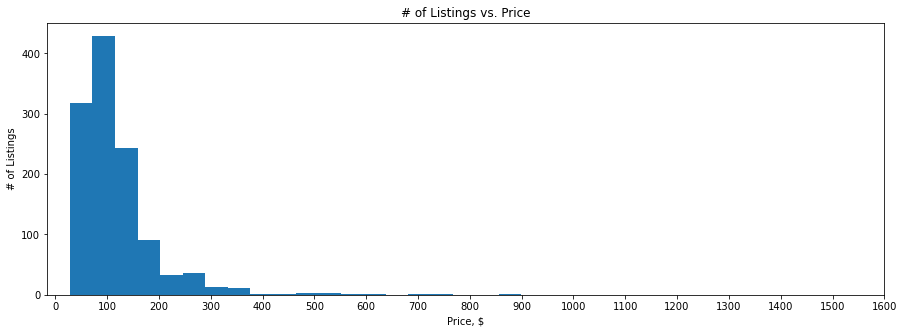

In [6]:
# 4. Analyze the data
# 4a. Find the aveage price for each listing
mean_listing_price = df2.groupby('listing_id').mean()['price']

plt.figure(figsize=(15,5))
plt.hist(mean_listing_price, bins=20)
plt.xticks(np.arange(0, 1700, step=100))
plt.ylabel("# of Listings")
plt.xlabel("Price, $")
plt.title("# of Listings vs. Price")
plt.show()

In [7]:
# 4b. Find out # of listings for different neighborhood, and answer to my 1st question - 
# top 3 locations with the most listings
listings_df['neighbourhood_group_cleansed'].value_counts().head(15) 

Other neighborhoods    794
Capitol Hill           567
Downtown               530
Central Area           369
Queen Anne             295
Ballard                230
West Seattle           203
Rainier Valley         159
University District    122
Beacon Hill            118
Cascade                 89
Northgate               80
Delridge                79
Lake City               67
Magnolia                61
Name: neighbourhood_group_cleansed, dtype: int64

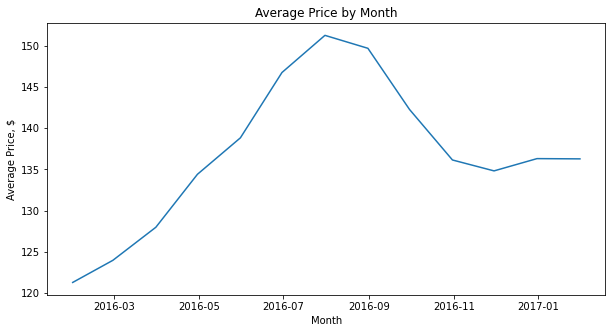

In [8]:
# 4c. Find average price by month, visualize it.
# and answer to my 2nd question - how listing price changes for different season or month?
calendar_df['price']=calendar_df['price'].apply(lambda x: str(x).replace('$',''))
calendar_df['price']=pd.to_numeric(calendar_df['price'],errors ='coerce')
df_calendar=calendar_df.groupby('date')[['price']].sum()
df_calendar['mean']=calendar_df.groupby('date')[['price']].mean()
df_calendar.columns = ['Total','Avg']

df_calendar2 = calendar_df.set_index('date')
df_calendar2.index = pd.to_datetime(df_calendar2.index)
df_calendar2 = df_calendar2[['price']].resample('M').mean()

average_price_by_month = df_calendar2.groupby(['date'])['price'].mean()

plt.figure(figsize=(10,5))
plt.plot(df_calendar2)
plt.xlabel('Month')
plt.ylabel('Average Price, $')
plt.title("Average Price by Month")
plt.savefig("Average Price by Month")
plt.show()

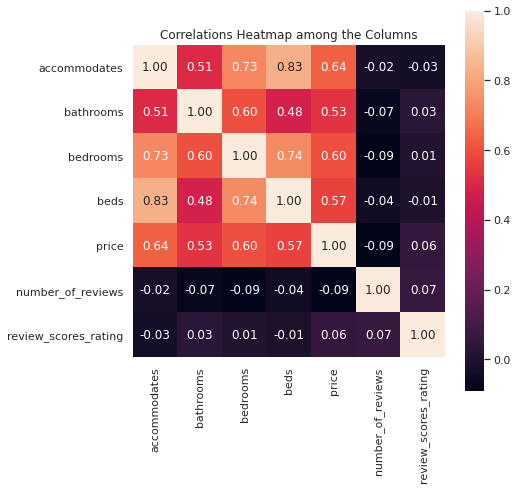

In [9]:
# 4d. Find out the correlation among the columns in the newly built dataframe,visualize it
# and answer to my 3rd question -  how does the other factors such as # of bedrooms or review scores impact the listing price?    

cols = ['accommodates','bathrooms','bedrooms','beds','price','number_of_reviews','review_scores_rating']

correlations = np.corrcoef(df2[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
htmp = sns.heatmap(correlations, cbar = True, annot = True, square = True, fmt = '.2f', yticklabels = cols, xticklabels = cols).set_title("Correlations Heatmap among the Columns")

figure = htmp.get_figure()
figure.savefig('correlations.png')